In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from deepgaze_pytorch.deepgaze2e import DeepGazeIIE
from  deepgaze_pytorch.features.normalizer import Normalizer
from deepgaze_pytorch.deepgaze2e_original import DeepGazeIIEE
import scipy.special
import pysaliency
from pysaliency.plotting import visualize_distribution
from scipy.ndimage import gaussian_filter, zoom
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter

In [24]:
class CenterBiasModel:
    """Center bias model from data.py"""
    def __init__(self, sigma=0.5):
        self.sigma = sigma
        self._cached_log_density = None
        self._cached_shape = None

    def log_density(self, stimulus):
        if stimulus is None:
            raise ValueError("Stimulus cannot be None")
           
        height, width = stimulus.shape[:2]
       
        if self._cached_log_density is not None and self._cached_shape == (height, width):
            return self._cached_log_density
       
        y = np.linspace(-1, 1, height, dtype=np.float32)[:, np.newaxis]
        x = np.linspace(-1, 1, width, dtype=np.float32)[np.newaxis, :]
        gaussian = np.exp(-(x**2 + y**2) / (2 * self.sigma**2))
        gaussian = gaussian / gaussian.sum()
        log_density = np.log(gaussian + 1e-20)
        log_density = log_density - scipy.special.logsumexp(log_density)
       
        self._cached_log_density = log_density
        self._cached_shape = (height, width)
       
        return log_density

In [25]:
def load_our_model(model_path, device):
    """Carga nuestro modelo entrenado."""
    print("Cargando nuestro modelo...")
    model = DeepGazeIIE(pretrained=False)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)
    model.eval()
    return model

In [26]:
def load_pretrained_model(device):
    """Carga el modelo pre-entrenado original manejando la discrepancia de estructura."""
    print("Cargando modelo pre-entrenado...")
    model = DeepGazeIIEE(pretrained=True)
    
    # # Descargar los pesos pre-entrenados
    # url = 'https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/deepgaze2e.pth'
    # state_dict = torch.hub.load_state_dict_from_url(url, map_location='cpu')
    
    # # Filtrar las keys que coinciden con nuestro modelo
    # model_dict = model.state_dict()
    # # pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict}
    # # model_dict.update(pretrained_dict)
    
    # # Cargar los pesos filtrados
    # model.load_state_dict(model_dict)
    model = model.to(device)
    model.eval()
    return model

In [27]:
def load_and_preprocess_image(image_path, target_size=(1920, 1080)):
    """Carga y preprocesa una imagen."""
    image = Image.open(image_path).convert('RGB')
    image = image.resize(target_size, Image.Resampling.LANCZOS)
    image_np = np.array(image)
    image_tensor = torch.tensor([image_np.transpose(2, 0, 1)])
    return image, image_np, image_tensor

In [28]:
def prepare_centerbias(image_np, mit_centerbias_template, our_centerbias_model):
    """Prepara ambos center bias para la imagen."""
    # Nuestro center bias
    our_cb = our_centerbias_model.log_density(image_np)
    our_cb_tensor = torch.tensor([our_cb])
    
    # MIT center bias
    mit_cb = zoom(mit_centerbias_template, 
                 (image_np.shape[0]/mit_centerbias_template.shape[0],
                  image_np.shape[1]/mit_centerbias_template.shape[1]), 
                 order=0, mode='nearest')
    mit_cb -= logsumexp(mit_cb)
    mit_cb_tensor = torch.tensor([mit_cb])
    
    return our_cb_tensor, mit_cb_tensor

In [29]:
def visualize_predictions(image, our_pred, pretrained_pred, filename):
    """Visualiza las predicciones de ambos modelos."""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f'Comparación para: {filename}', fontsize=16)
    
    # Primera fila - Nuestro modelo
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Imagen Original')
    axes[0, 0].set_axis_off()
    
    axes[0, 1].matshow(our_pred)
    axes[0, 1].set_title('Nuestro Modelo\nLog Density')
    axes[0, 1].set_axis_off()
    
    visualize_distribution(our_pred, ax=axes[0, 2])
    axes[0, 2].set_title('Nuestro Modelo\nPredicción')
    axes[0, 2].set_axis_off()
    
    # Segunda fila - Modelo pre-entrenado
    axes[1, 0].imshow(image)
    axes[1, 0].set_title('Imagen Original')
    axes[1, 0].set_axis_off()
    
    axes[1, 1].matshow(pretrained_pred)
    axes[1, 1].set_title('Modelo Original\nLog Density')
    axes[1, 1].set_axis_off()
    
    visualize_distribution(pretrained_pred, ax=axes[1, 2])
    axes[1, 2].set_title('Modelo Original\nPredicción')
    axes[1, 2].set_axis_off()
    
    plt.tight_layout()
    plt.show()

In [30]:
def compare_models(our_model_path, input_folder, mit_centerbias_path):
    """Función principal para comparar modelos."""
    # Configurar device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Usando dispositivo: {device}")
    
    # Cargar modelos
    our_model = load_our_model(our_model_path, device)
    pretrained_model = load_pretrained_model(device)
    
    # Preparar componentes
    our_centerbias = CenterBiasModel()
    mit_centerbias_template = np.load(mit_centerbias_path)
    
    # Procesar imágenes
    valid_extensions = ('.jpg', '.jpeg', '.png')
    image_files = [f for f in os.listdir(input_folder) 
                  if f.lower().endswith(valid_extensions)]
    
    print(f"\nEncontradas {len(image_files)} imágenes para procesar")
    
    for filename in image_files:
        print(f"\nProcesando: {filename}")
        image_path = os.path.join(input_folder, filename)
        
        # Cargar y preprocesar imagen
        image, image_np, image_tensor = load_and_preprocess_image(image_path)
        image_tensor = image_tensor.to(device)
        
        # Preparar center bias
        our_cb, mit_cb = prepare_centerbias(image_np, mit_centerbias_template, our_centerbias)
        our_cb = our_cb.to(device)
        mit_cb = mit_cb.to(device)
        
        # Obtener predicciones
        with torch.no_grad():
            our_pred = our_model(image_tensor, our_cb)
            pretrained_pred = pretrained_model(image_tensor, mit_cb)
            
            our_pred = our_pred.cpu().numpy()[0, 0]
            pretrained_pred = pretrained_pred.cpu().numpy()[0, 0]
        
        # Visualizar resultados
        visualize_predictions(image, our_pred, pretrained_pred, filename)
        


In [31]:
if __name__ == "__main__":
    MODEL_PATH = r"C:\Users\Adrian\Desktop\deepgaze_pytorch\deepgaze_pytorch\checkpoints\final.pth"
    INPUT_FOLDER = r"c:\Users\Adrian\Desktop\imagenes_de_prueba"
    MIT_CENTERBIAS_PATH = r"C:\Users\Adrian\Desktop\ggg\Deep_Learning_Eye_Gaze\DeepGazeIIE\centerbias\centerbias_mit1003.npy"

In [32]:
# Configurar dispositivo y componentes
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


Usando dispositivo: cuda
Cargando nuestro modelo...
Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\Adrian/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\Adrian/.cache\torch\hub\pytorch_vision_v0.6.0


Cargando modelo pre-entrenado...
Loaded pretrained weights for efficientnet-b5


Using cache found in C:\Users\Adrian/.cache\torch\hub\pytorch_vision_v0.6.0
Using cache found in C:\Users\Adrian/.cache\torch\hub\pytorch_vision_v0.6.0



Encontradas 5 imágenes para procesar

Procesando: 028.jpg


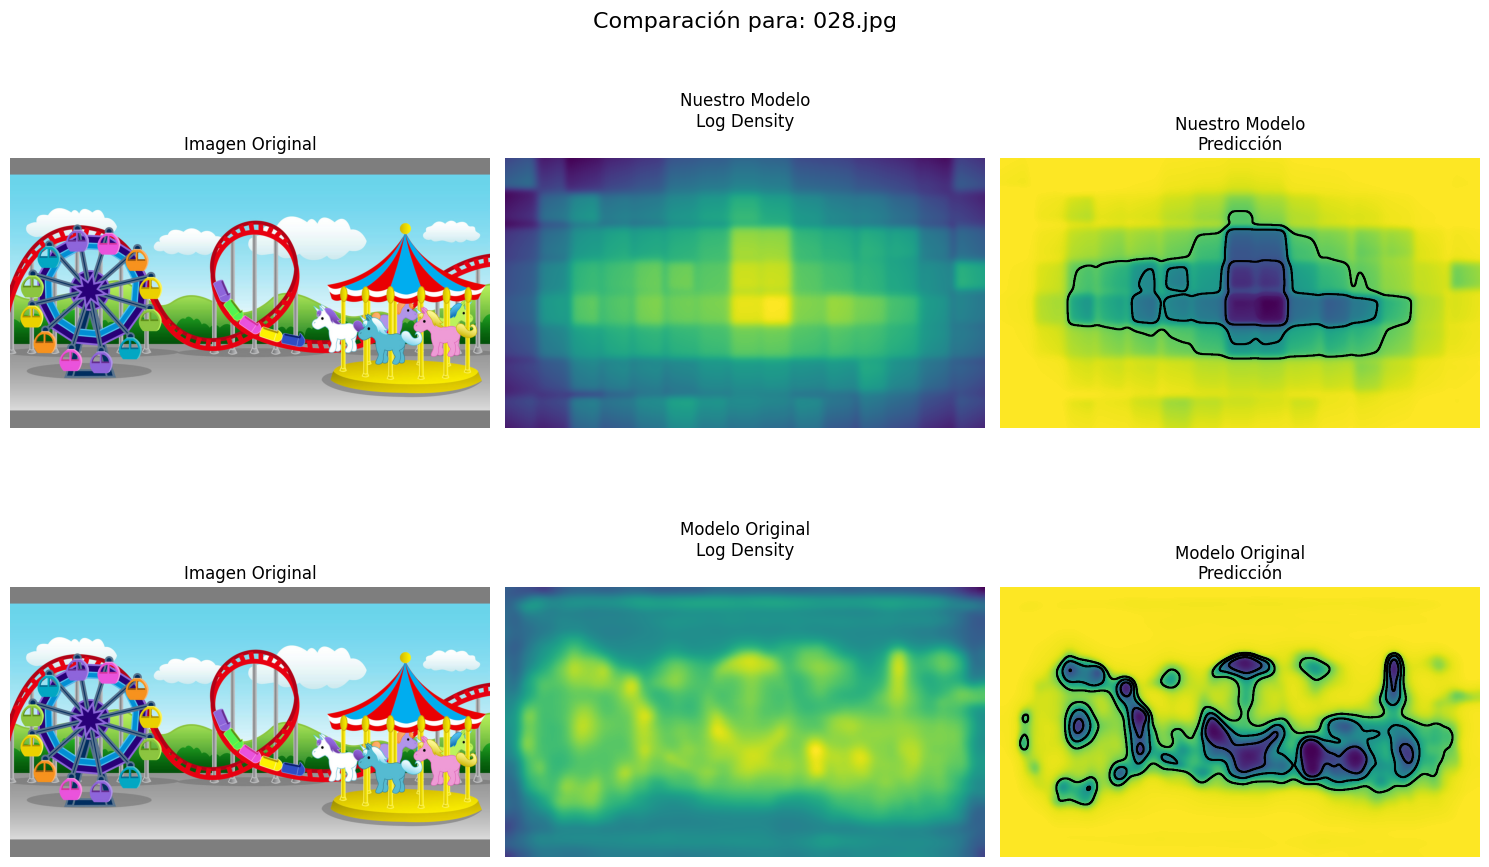


Procesando: 158.jpg


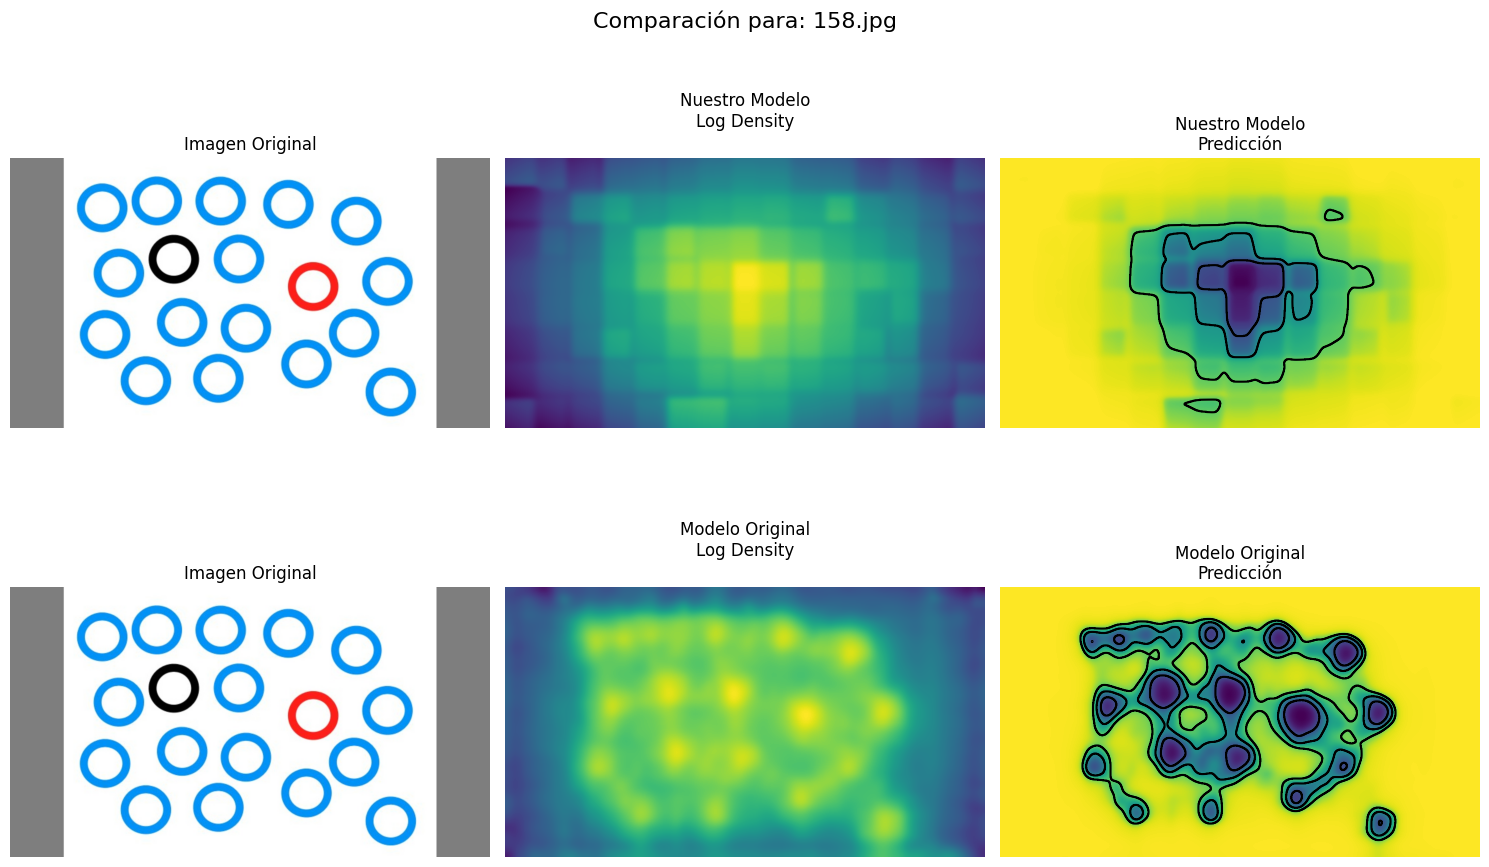


Procesando: 180.jpg


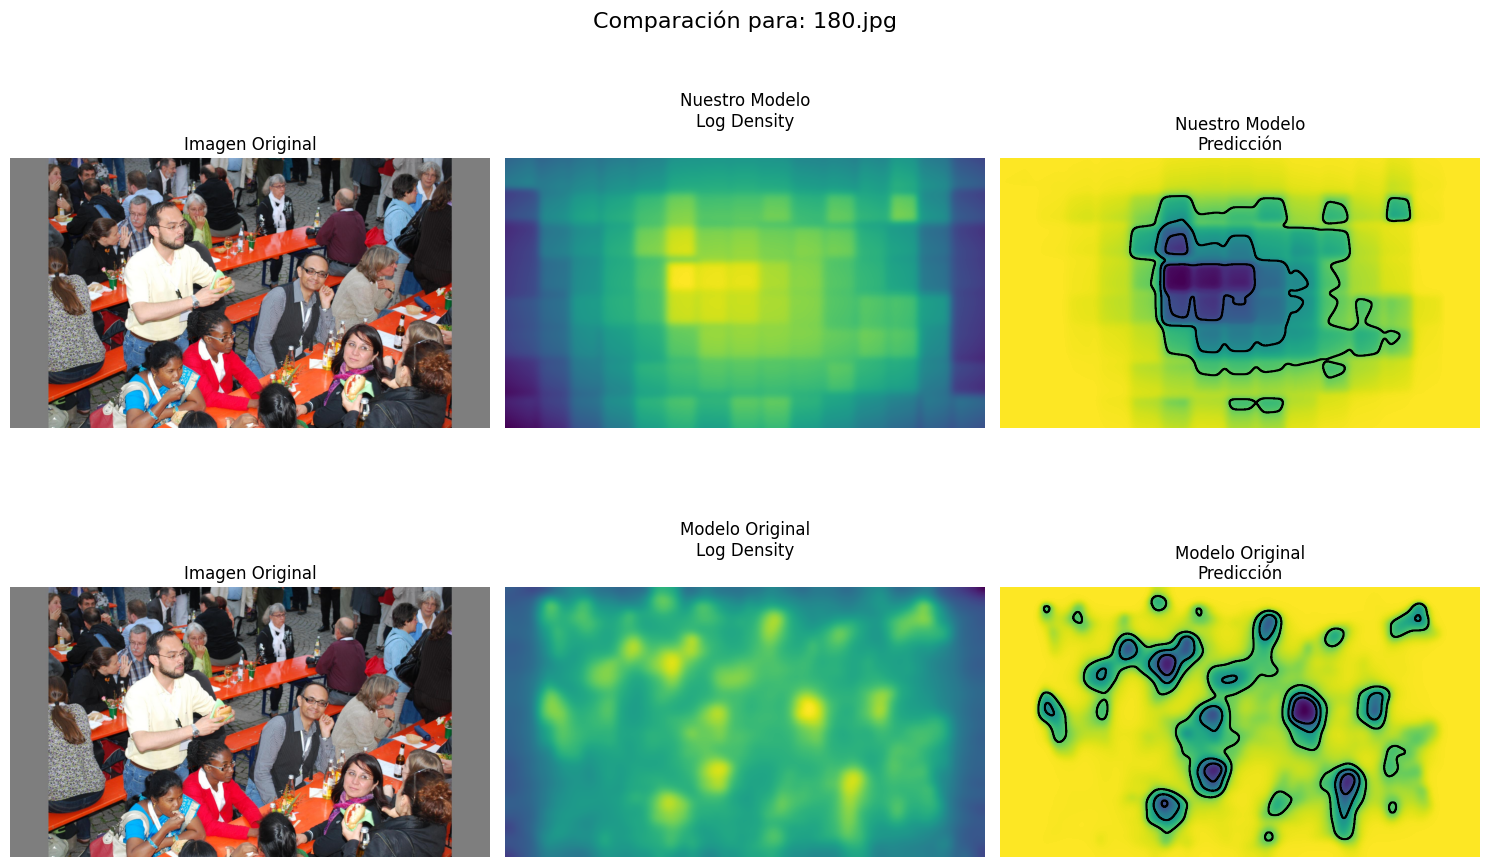


Procesando: 190.jpg



Procesando: 9107ae4604381c7cada00ea3ba2b33e3.jpg


In [33]:
compare_models(MODEL_PATH, INPUT_FOLDER, MIT_CENTERBIAS_PATH)